# Data Source
Capstone Project Name: PRCP-1001-RiceLeaf
Images (.jpg format) of Diseased Rice-Leaves as mentioned below:

###
1) Leaf smut - 39 images (.jpg)
2) Brown spot - 40 images (.jpg)
3) bacterial leaf blight - 40 images (.jpg)*

# Objective
The objective is to train a Deep Neural Network model using the abovementioned images to identify the corresonding disease in the rice plant.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.gridspec as gridspec
import random
import math

from sklearn.preprocessing import label_binarize,  LabelBinarizer

from sklearn.model_selection import train_test_split


In [ ]:
import cv2
import random
import os
from os import listdir
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers,utils
from tensorflow.keras.utils import img_to_array, array_to_img
from tensorflow.keras.optimizers import SGD, Adam, AdamW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import regularizers

from tensorflow.keras.models import model_from_json
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall, F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.regularizers import l2


In [ ]:
# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    min_delta=0.001
)


def cosine_annealing(epoch, lr_max=0.001, lr_min=0.00001, epochs=150):
    lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / epochs))
    return lr


In [ ]:
def plot_images(title, path, num_images):
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(10, 4)
    fig.suptitle(title, fontsize=20)

    for i in range(num_images):
        ax = fig.add_subplot(gs[i])
        image = imread(path + '/' + random.choice(sorted(os.listdir(path))))
        ax.imshow(image)
        ax.text(10, 20, f"{image.shape[1]}x{image.shape[0]}", fontsize=10, color='green')
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
# import tensorflow as tf
# import numpy as np

def label_to_classes(x: int) -> str:
    """
    Maps disease labels to their corresponding class names.

    Args:
    x (int): Disease label.

    Returns:
    str: Disease class name or None if label is not found.

    Examples:
    >>> label_to_classes(0)
    'Bacterial leaf blight'
    """
    disease_class = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
    disease_labels = [0, 1, 2]
    disease_dict = {label: class_name for label, class_name in zip(disease_labels, disease_class)}
    return disease_dict.get(x, None)


def label_to_classes_map(vec: tf.Tensor | np.ndarray | list) -> list:
    """
    Applies label_to_classes mapping to each element of the input vector.

    Args:
    vec (list or numpy array or TensorFlow tensor): Vector of disease labels.

    Returns:
    list: Vector of corresponding disease class names.

    Raises:
    TypeError: If input is not a list, numpy array, or TensorFlow tensor.

    Examples:
    >>> label_to_classes_map([0, 1, 2])
    ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
    """
    if not isinstance(vec, (tf.Tensor, np.ndarray, list)):
        raise TypeError("Input must be a list, numpy array, or TensorFlow tensor.")

    # Convert tensor to numpy array if necessary
    vec = vec.numpy() if isinstance(vec, tf.Tensor) else vec

    # Use list comprehension for mapping
    return [label_to_classes(x) for x in vec]




In [ ]:
import tensorflow as tf

def calculate_equal_percentage(tensor1, tensor2):
    """
    Calculate the percentage of equal elements between two tensors.

    Args:
        tensor1 (tf.Tensor): The first tensor.
        tensor2 (tf.Tensor): The second tensor.

    Returns:
        float: The percentage of equal elements.
    """
    # Check if tensors have the same shape
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have the same shape")

    # Compare elements-wise
    equal_elements = tf.equal(tensor1, tensor2)

    # Count the number of True values (i.e., equal elements)
    num_equal = tf.reduce_sum(tf.cast(equal_elements, tf.int32))

    # Calculate the total number of elements
    total_elements = tf.size(tensor1)

    # Calculate the percentage of equal elements
    percentage_equal = (num_equal / total_elements) * 100

    return percentage_equal


# Example usage
tensor1 = tf.constant([1, 2, 3])
tensor2 = tf.constant([1, 4, 3])

percentage = calculate_equal_percentage(tensor1, tensor2)
print("Percentage of equal elements: {:.2f}%".format(percentage))

Percentage of equal elements: 66.67%


In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data"

'Bacterial leaf blight'  'Brown spot'  'Leaf smut'


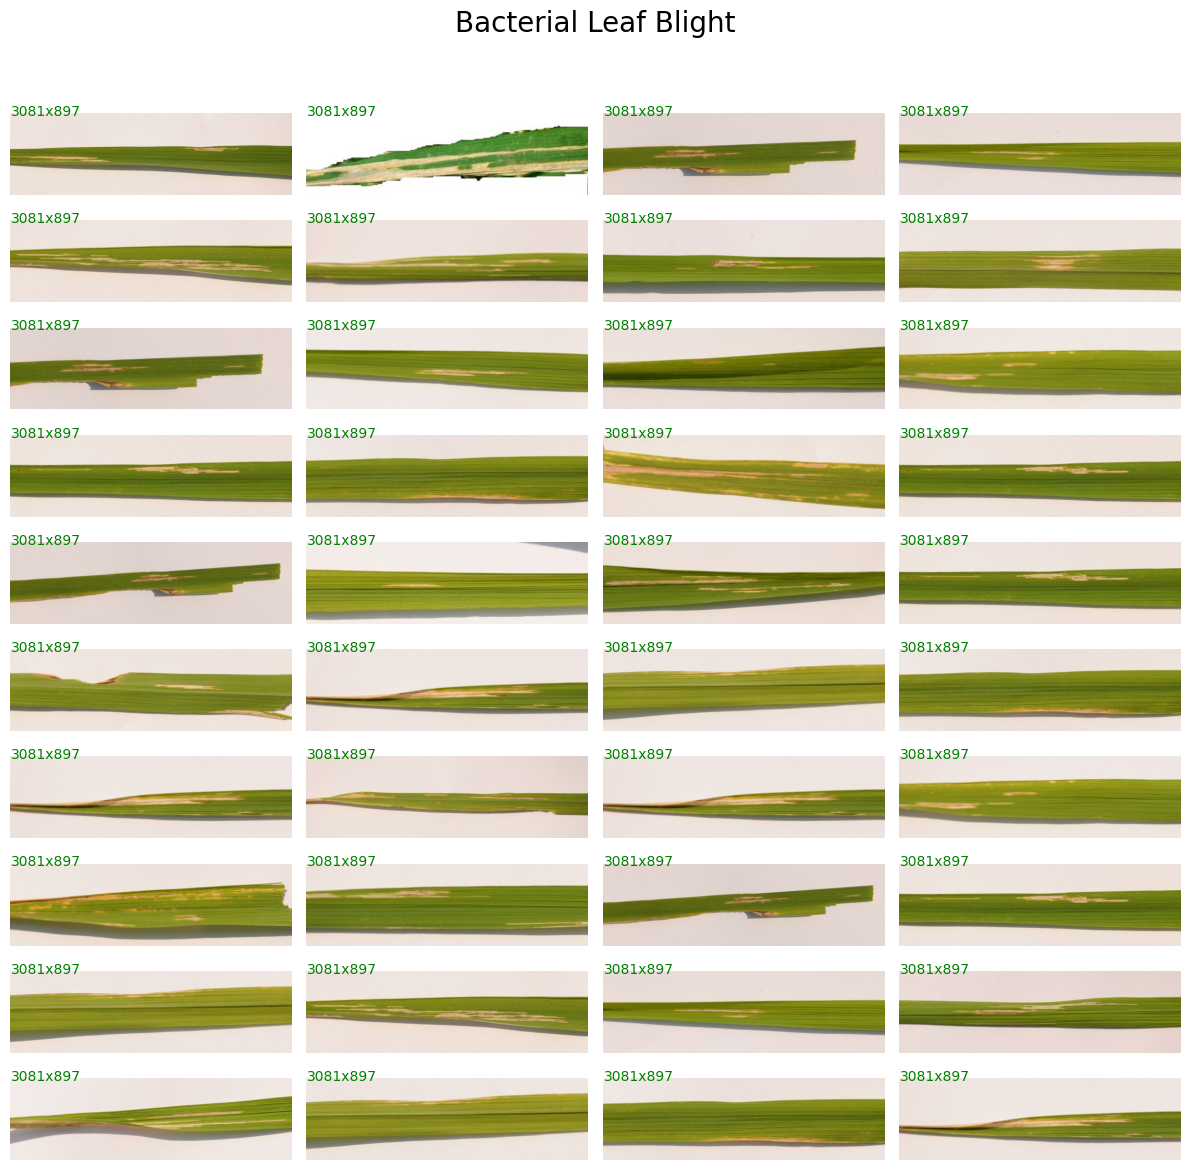

In [ ]:
# Plotting 40 images to check dataset
# Bacterial leaf blight
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(10, 4)

# Set title for the entire plot
fig.suptitle('Bacterial Leaf Blight', fontsize=20)

path = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Bacterial leaf blight/Bacterial leaf blight"
for i in range(40):
    ax = fig.add_subplot(gs[i])
    bacterial_leaf_blight = imread(path + '/' + random.choice(sorted(os.listdir(path))))
    ax.imshow(bacterial_leaf_blight)

    # Display image dimensions as text on the image
    ax.text(10, 20, f"{bacterial_leaf_blight.shape[1]}x{bacterial_leaf_blight.shape[0]}", fontsize=10, color='green')

    ax.axis('off')  # Remove axis and scale

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Observation:
These images correspond to the leaves from plant infected with Bacterial Leaf Blight

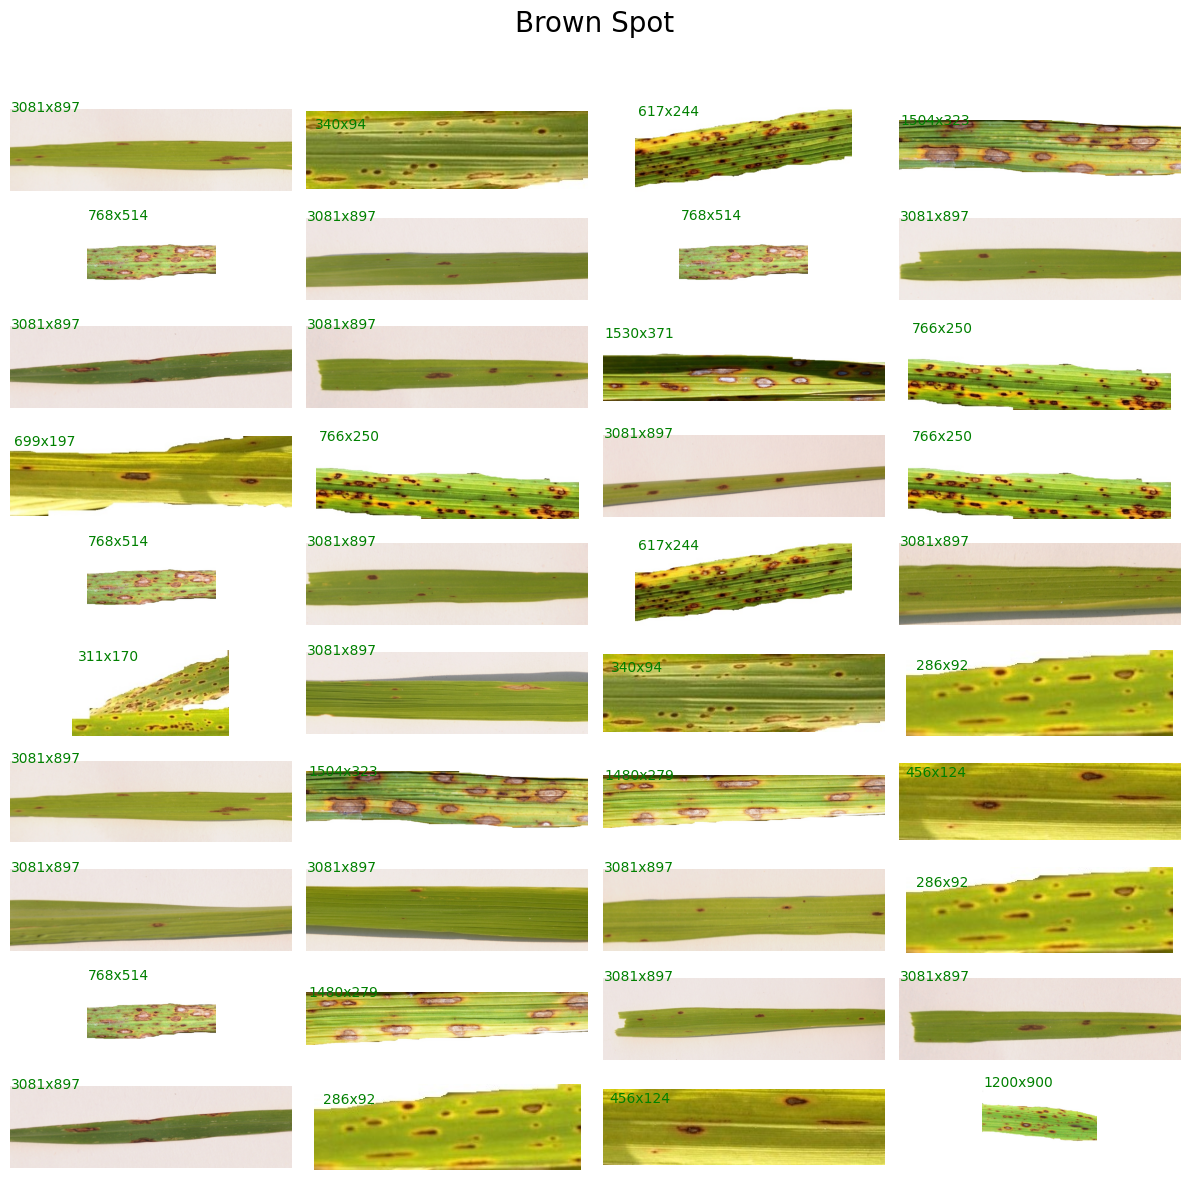

In [ ]:
# Plotting 40 images to check dataset
# Brown Spot
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(10, 4)

# Set title for the entire plot
fig.suptitle('Brown Spot', fontsize=20)

path = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Brown spot/Brown spot"
for i in range(40):
    ax = fig.add_subplot(gs[i])
    brown_spot = imread(path + '/' + random.choice(sorted(os.listdir(path))))
    ax.imshow(brown_spot)

    # Display image dimensions as text on the image
    ax.text(10, 20, f"{brown_spot.shape[1]}x{brown_spot.shape[0]}", fontsize=10, color='green')

    ax.axis('off')  # Remove axis and scale

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Observation:
These images correspond to the leaves from plant infected with Brown Spot Leaves

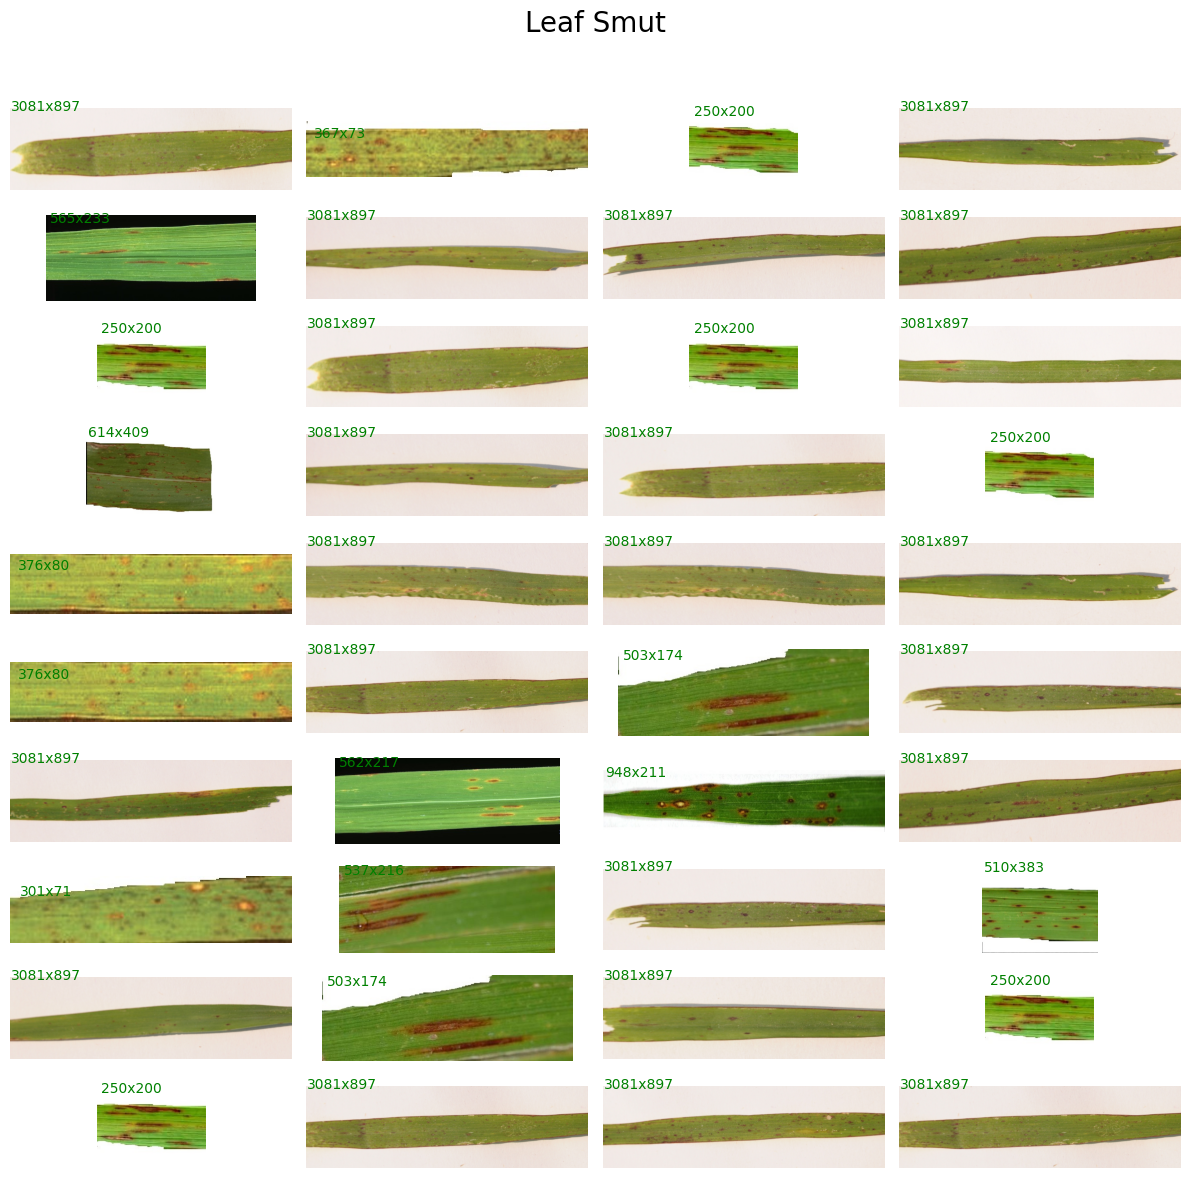

In [ ]:
# Plotting 40 images to check dataset
# Leaf Smut
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(10, 4)

# Set title for the entire plot
fig.suptitle('Leaf Smut', fontsize=20)

path = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Leaf smut/Leaf smut"
for i in range(40):
    ax = fig.add_subplot(gs[i])
    leaf_smut = imread(path + '/' + random.choice(sorted(os.listdir(path))))
    ax.imshow(leaf_smut)

    # Display image dimensions as text on the image
    ax.text(10, 20, f"{leaf_smut.shape[1]}x{leaf_smut.shape[0]}", fontsize=10, color='green')

    ax.axis('off')  # Remove axis and scale

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Observation:
These images correspond to the leaves from plant infected with Leaf Smut

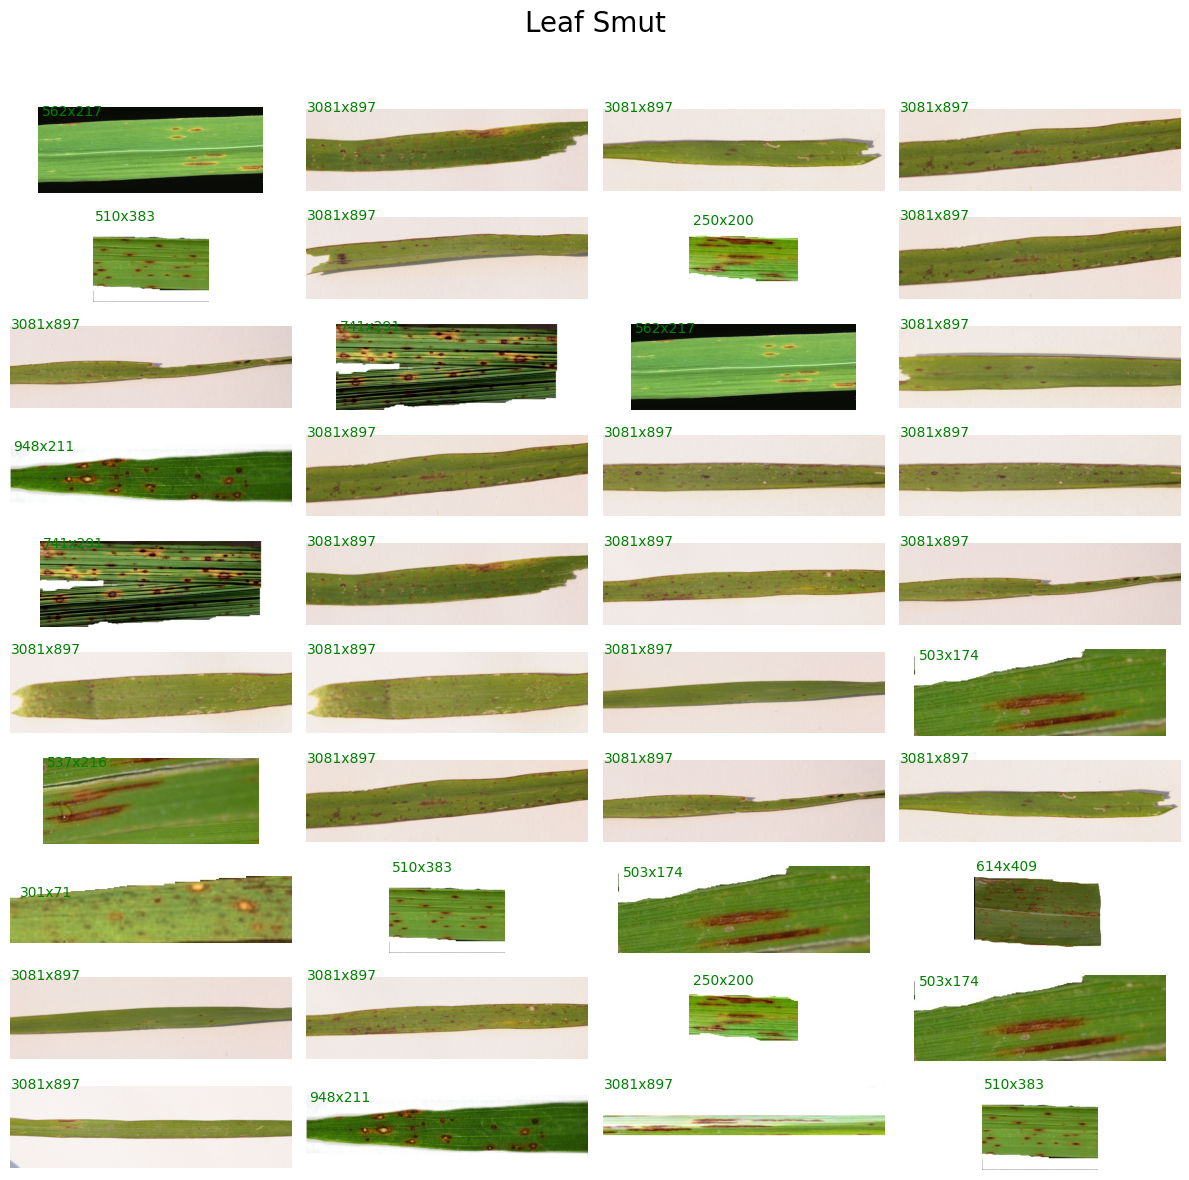

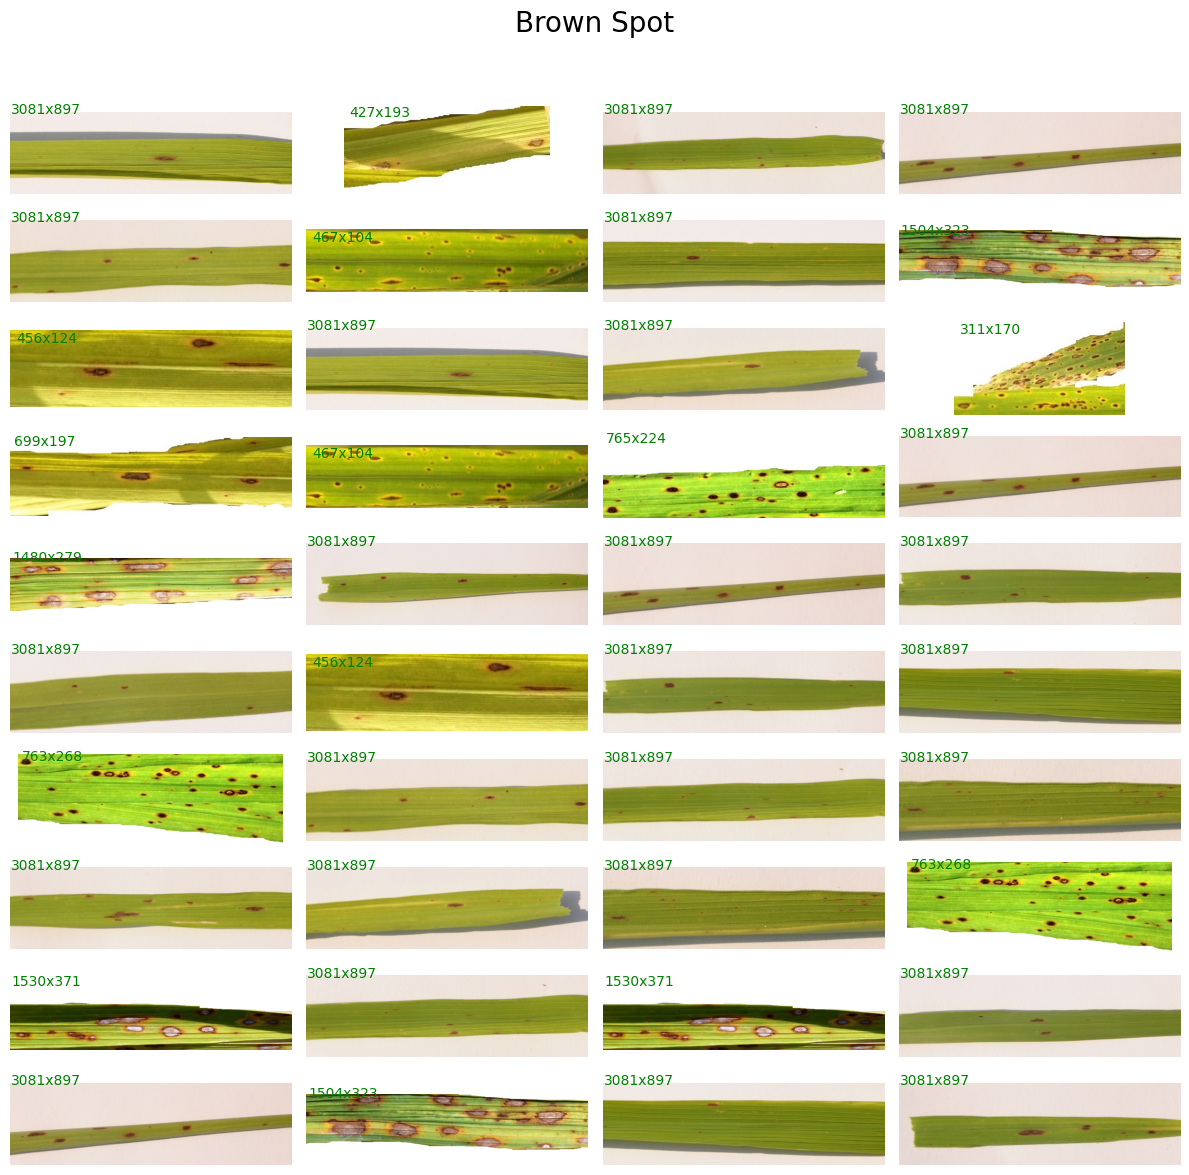

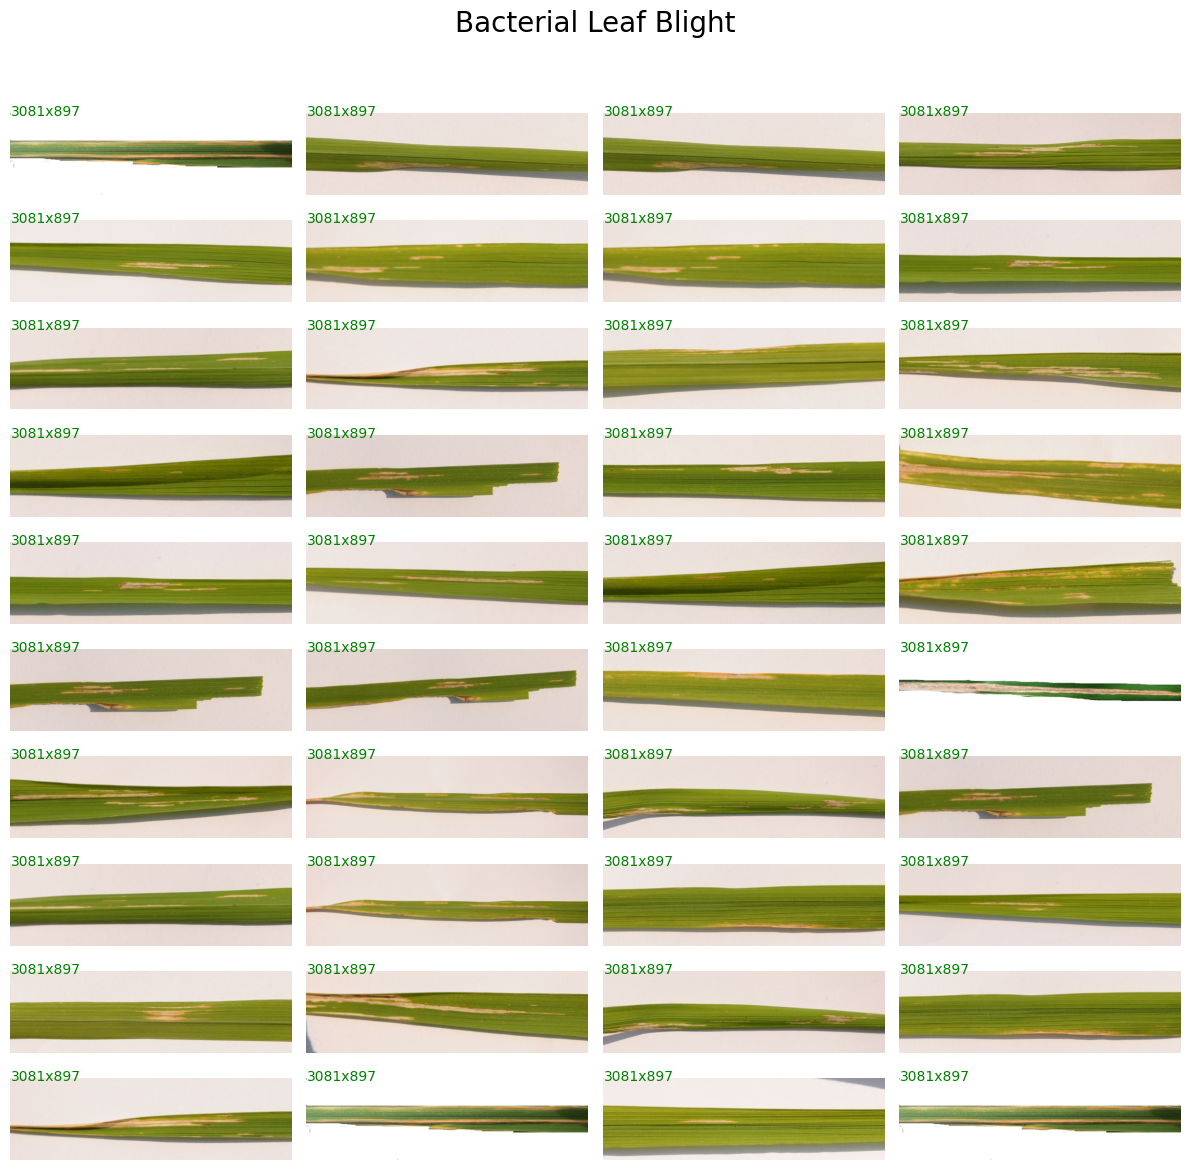

In [ ]:


# Plotting 40 images to check dataset
plot_images('Leaf Smut', "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Leaf smut/Leaf smut", 40)
plot_images('Brown Spot', "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Brown spot/Brown spot", 40)
plot_images('Bacterial Leaf Blight', "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data/Bacterial leaf blight/Bacterial leaf blight", 40)

### Next plan of actions:
After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (128,384))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
# Define constants
DATA_DIR = "/content/gdrive/MyDrive/Machine_Learning/Datasets/CNN/PRCP-1001-RiceLeaf/Data"
LABELS = ['Bacterial leaf blight/Bacterial leaf blight', 'Brown spot/Brown spot', 'Leaf smut/Leaf smut']
TARGET_LABELS = [0, 1, 2]

# Initialize lists
image_list, label_list = [], []

# Reading and converting image to numpy array
for label, directory in zip(TARGET_LABELS, LABELS):
  plant_image_list = os.listdir(os.path.join(DATA_DIR, directory))
  for file in plant_image_list:
    image_path = os.path.join(DATA_DIR, directory, file)
    image = load_img(image_path, target_size=(384, 128))
    image_array = img_to_array(image)
    image_list.append(image_array)
    label_list.append(label)

# Convert lists to numpy arrays
image_array = np.array(image_list)
label_array = np.array(label_list)

# Checking the shape of the converted numpy array
print(image_array.shape)
print(label_array.shape)

(119, 384, 128, 3)
(119,)


In [ ]:
# Randomize the order of image_array and label_array
indices = np.random.permutation(len(image_array))
image_array = image_array[indices]
label_array = label_array[indices]

print(image_array.shape)
print(label_array.shape)


(119, 384, 128, 3)
(119,)


### Observation:
- In the above cell we have encoded the various disease categories (target categories) into taget_lables (numbers: 0, 1 & 2).
- Then, We converted all the training images into numpy arrays.
- We randomized the dataset

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0
0    40
1    40
2    39
Name: count, dtype: int64

###Observation:
Checked the number of images of various class labels and hence, confirmed the image dataset to be balanced:

In [ ]:
#Checking the shape of the converted numpy array
image_list[0].shape

(384, 128, 3)

###Observation:
- The colored images have been converted into a 3-D Matrix (Pixel_Pos_Height, Pixel_Pos_Width,RGB_Channel)
  

In [ ]:
label_list = np.array(label_list)
label_list.shape

(119,)

###Observation:
- Checking the total number of the images which is the length of the labels list.

### Next plan of action:
- Now that we have converted all our images into numpy arrays, let us we  use sklearn train_test_split to split the dataset into testing and training data.
- Here we will test size as 0.2 so my data will be divided into 80% training and 20% testing data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, stratify=label_list, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2,stratify=y_train,random_state=42)

In [ ]:
print(x_train[0].shape)
print(x_val[0].shape)
print(x_test[0].shape)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)


(384, 128, 3)
(384, 128, 3)
(384, 128, 3)
(76, 384, 128, 3)


# Data Augmentation

We will use TensorFlow Data Augmentation only on training data to generate more training images

In [ ]:
# Data Augmentation
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.98, 1.02],  # Brightness variation within 2% window
)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(76, 384, 128, 3)
(76,)


In [ ]:
# Create augmented data generator
train_generator = datagen.flow(
    x_train,
    y_train,
    batch_size=16,
    shuffle=True
)

# Initialize empty lists
x_train_aug = []
y_train_aug = []

# Get augmented data and labels
for _ in range(63):  # 63 batches of 16 = 1008 instances
    x_batch, y_batch = next(train_generator)
    x_train_aug.extend(x_batch)
    y_train_aug.extend(y_batch)

# Convert lists to numpy arrays
x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)

### Normalise the pixel values:
- Now, we will normalize the dataset of our images to values between 0 & 1.
- This will reduce computation time and bring all the pixel samples to same scale (0 to 1).
- As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.
- Also, let us reshape the array of each sample to 768,256,3 in order to maintain constant aspect ratio.

In [ ]:
#Scaling the pixel sizes to between 0 & 1:
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_train_aug = np.array(x_train_aug, dtype=np.float16) / 255.0
x_val = np.array(x_val, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0

#reshaping the array to maintain the aspect ratio of the image:
x_train = x_train.reshape( -1, 384,128,3)
x_train_aug = x_train_aug.reshape( -1, 384,128,3)
x_val = x_val.reshape( -1, 384,128,3)
x_test = x_test.reshape( -1, 384,128,3)

In [ ]:
#Checking for first sample (array) in the x_train
x_train[0,:,:,:]


array([[[1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        ...,
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ]],

       [[1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        ...,
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ]],

       [[1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        ...,
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ],
        [1.      , 1.      , 1.      ]],

       ...,

       [[0.965   , 0.9805  , 0.9766  ],
        [0.992   , 1.      , 0.996   ],
        [0.9883  , 0.996   , 0.992   ],
        ...,
        [1.      , 1.      , 1.      ],
        [0.996   , 0.996   , 0.996   ],
        [

In [ ]:
#Checking for first sample (array) in the x_train_aug
x_train_aug[0,:,:,:]


array([[[0.651   , 0.714   , 0.051   ],
        [0.651   , 0.714   , 0.051   ],
        [0.651   , 0.714   , 0.051   ],
        ...,
        [0.5767  , 0.537   , 0.03137 ],
        [0.533   , 0.5137  , 0.011765],
        [0.5176  , 0.506   , 0.0196  ]],

       [[0.651   , 0.714   , 0.051   ],
        [0.651   , 0.714   , 0.051   ],
        [0.651   , 0.714   , 0.051   ],
        ...,
        [0.5767  , 0.537   , 0.03137 ],
        [0.533   , 0.5137  , 0.011765],
        [0.5215  , 0.506   , 0.0196  ]],

       [[0.651   , 0.714   , 0.051   ],
        [0.651   , 0.714   , 0.051   ],
        [0.651   , 0.714   , 0.051   ],
        ...,
        [0.5767  , 0.537   , 0.03137 ],
        [0.533   , 0.5137  , 0.011765],
        [0.5215  , 0.506   , 0.0196  ]],

       ...,

       [[0.745   , 0.6943  , 0.08234 ],
        [0.745   , 0.6943  , 0.08234 ],
        [0.745   , 0.6943  , 0.08234 ],
        ...,
        [0.4392  , 0.4275  , 0.051   ],
        [0.3804  , 0.3687  , 0.02353 ],
        [

In [ ]:
#Checking for shape of array corresponding to image samples
print(x_train[0,:,:,:].shape,x_train[-1,:,:,:].shape)


(384, 128, 3) (384, 128, 3)


In [ ]:
#Checking for shape of array corresponding to augmented image samples
print(x_train_aug[0,:,:,:].shape,x_train_aug[-1,:,:,:].shape)


(384, 128, 3) (384, 128, 3)


In [ ]:
#Checking for shape of x_train
x_train.shape

(76, 384, 128, 3)

In [ ]:
#Checking for shape of x_train_aug
x_train_aug.shape

(960, 384, 128, 3)

In [ ]:
#Checking for shape of x_train
x_test.shape

(24, 384, 128, 3)

In [ ]:
#Checking for dtype of array corresponding to image samples
print(x_train[0,:,:,:].dtype,x_train[-1,:,:,:].dtype)


float16 float16


In [ ]:
#Checking for dtype of array corresponding to augmented image samples
print(x_train_aug[0,:,:,:].dtype,x_train_aug[-1,:,:,:].dtype)


float16 float16


### Observations:
- x_train shape: (95, 384,128,3)
- x_train_aug shape: (___, 384,128,3)
- x_test shape: (24, 384,128,3)
- datatype of the sample array (tensor) float16

### Convert the Target into categorical type:
- As, our business case is to classify the type of disease in the leaf samples (classification problem) we can convert the target variable (target labels (0,1,2) as categorical datatype for further processing.  

In [ ]:
# Checking the datatype
print(y_train.dtype,y_train_aug.dtype,y_val.dtype, y_test.dtype)

int64 int64 int64 int64


In [ ]:
y_train_class = y_train[:]
y_train_aug_class = y_train_aug[:]
y_val_class = y_val[:]
y_test_class = y_test[:]

In [ ]:
# Converting the target feature (one-hot encoding) for Keras (Tensorflow2)
y_train = to_categorical(y_train)
y_train_aug = to_categorical(y_train_aug)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# Checking the datatype after conversion
print(y_train.dtype,y_train_aug.dtype,y_val.dtype, y_test.dtype)

float64 float64 float64 float64


In [ ]:
# #Let us split the train dataset into train & validation dataset
# x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,stratify=y_train,random_state=42)

# Initialize a CNN Object from keras module:

- Let us create a sequential CNN model using keras and hence add successive convolution layers, pooling layers, flattening layer, dense layer, and activation layer as mentioned below:


Case--> I:
As the images of the diseased leaves don't have much contrasting pixels, instead of using MaxPooling2D layer, let us first try AveragePoolingLayer from Keras.

In [ ]:
num_classes = 3

model1 = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(384, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='swish'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='gelu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# # Define Reduce Learning Rate on Plateau
# rlrp = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=25,
#     min_lr=1e-6
# )




In [ ]:
# Creating an SGD optimizer object
opt = SGD(
    learning_rate=0.0005,  # Initial learning rate, will be adjusted by lr_scheduler
    momentum=0.9,  # Lower momentum to reduce oscillations
    nesterov=True,  # Maintain Nesterov acceleration for stability
)

# Compile the model
model1.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=[
        #Accuracy(),
        'accuracy',
        Precision(),
        Recall(),
        AUC(),
        F1Score(average='macro')  # F1-score, macro average
    ]
    )

In [ ]:
# Training the model with Adam optimizer for 500 epochs
epochs = 150
batch_size = 16


cosine_callback = LearningRateScheduler(cosine_annealing)

# Train model
history1 = model1.fit(x_train_aug, y_train_aug,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val, y_val),
                      verbose=1,
                      callbacks=[early_stop, cosine_callback])

Epoch 1/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.5076 - auc: 0.6771 - f1_score: 0.5075 - loss: 1.1736 - precision: 0.5168 - recall: 0.4265 - val_accuracy: 0.5263 - val_auc: 0.5983 - val_f1_score: 0.4157 - val_loss: 1.1066 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6705 - auc: 0.8494 - f1_score: 0.6698 - loss: 0.7684 - precision: 0.7062 - recall: 0.6405 - val_accuracy: 0.3158 - val_auc: 0.5540 - val_f1_score: 0.1600 - val_loss: 1.1965 - val_precision: 0.3158 - val_recall: 0.3158 - learning_rate: 4.9995e-04
Epoch 3/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7318 - auc: 0.8879 - f1_score: 0.7304 - loss: 0.6554 - precision: 0.7467 - recall: 0.6796 - val_accuracy: 0.3158 - val_auc: 0.5789 - val_f1_score: 0.1600 - val_loss: 1.4177 - val_precision: 0.3158 - val_recall: 0.3158 - learning_rate: 4.9973e-04
Epoch 4/150
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accu

### Plotting the training graph of model-1 through various epochs
Let's plot the accuracy of the model for the trainig history.

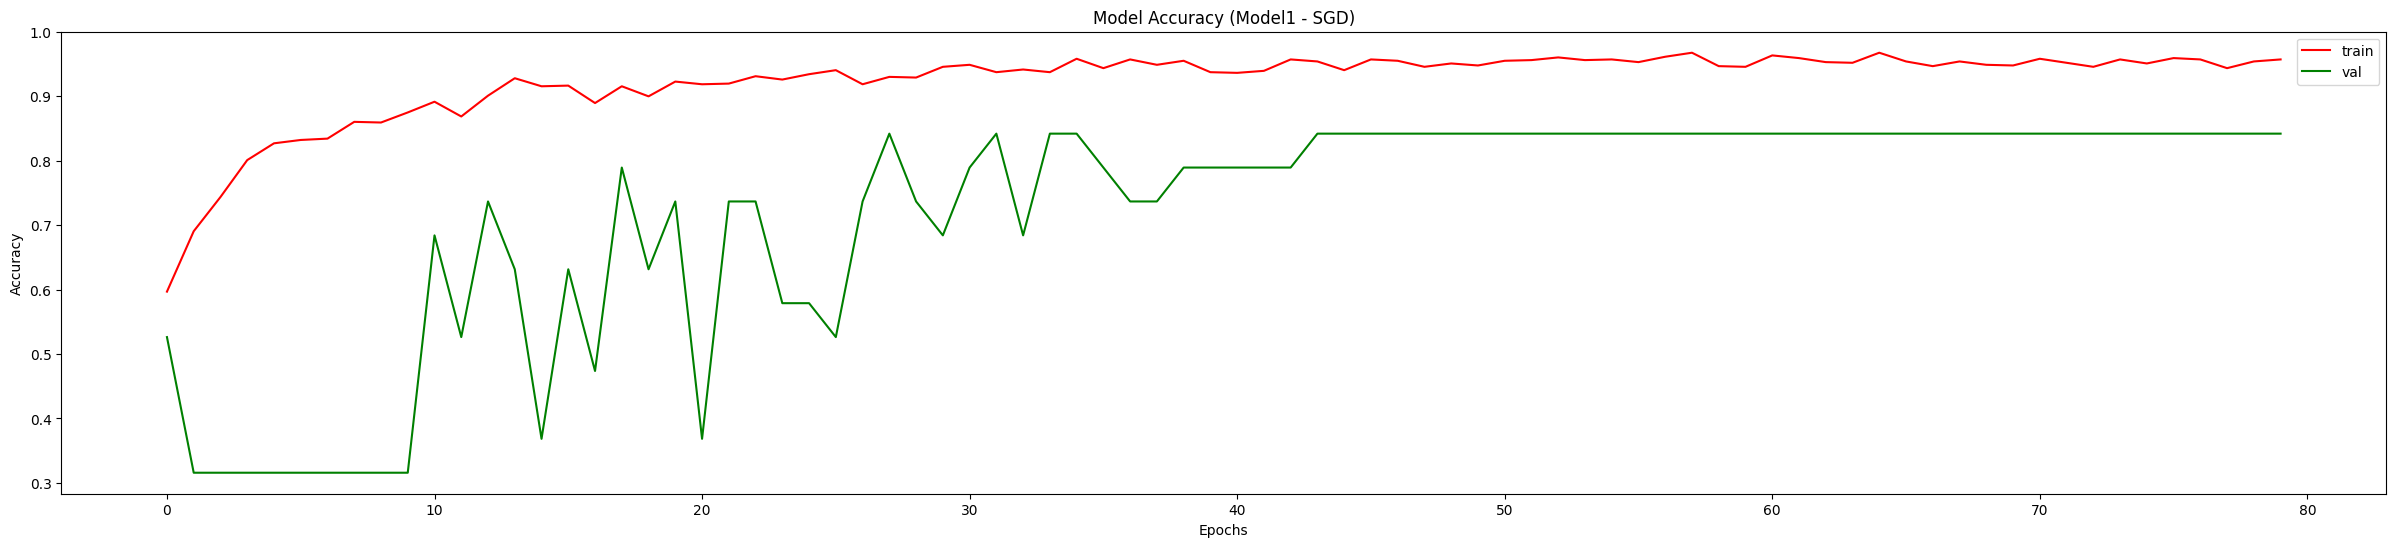

In [ ]:
#Plot the training history
plt.figure(figsize=(30, 6))
plt.title('Model1')
plt.title('Plot of training Epoches (Model1)')
plt.plot(history1.history['accuracy'], color='r')
plt.plot(history1.history['val_accuracy'], color='g')
plt.title('Model Accuracy (Model1 - SGD)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()



### Observations:
From the plot, it can be observed that:
- The train accuracy is very high (>98%) whereas the validation accuracy is moderately good around 70%.

### Checking for Test Accuracy
- Now, let's check the accuracy of the trained model (Model1) for test data.

In [ ]:
print("[INFO] Calculating model accuracy (Model1)")
scores1 = model1.evaluate(x_test, y_test)
print(f"Test Accuracy using Model1: {scores1[1]*100}")

[INFO] Calculating model accuracy (Model1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - auc: 0.8646 - f1_score: 0.7237 - loss: 0.9997 - precision: 0.7391 - recall: 0.7083
Test Accuracy using Model1: 75.0


In [ ]:
# Predicting the test data using this model
y_pred1 = model1.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


In [ ]:
y_pred1

array([[1.39608026e-01, 6.08522654e-01, 2.51869351e-01],
       [2.15736367e-02, 9.78371382e-01, 5.49080432e-05],
       [5.05283594e-01, 1.67125359e-01, 3.27590972e-01],
       [1.95203386e-02, 9.80277717e-01, 2.01927542e-04],
       [9.98257458e-01, 5.74736332e-04, 1.16779539e-03],
       [3.31969783e-02, 8.20533872e-01, 1.46269172e-01],
       [9.97595251e-01, 1.97935966e-03, 4.25391627e-04],
       [1.88038349e-02, 1.88613049e-05, 9.81177330e-01],
       [9.93906856e-01, 5.75135602e-03, 3.41698003e-04],
       [1.22000903e-01, 8.70542884e-01, 7.45616667e-03],
       [2.08665684e-01, 7.90757477e-01, 5.76852064e-04],
       [4.81421053e-01, 5.18024266e-01, 5.54668834e-04],
       [9.99074459e-01, 7.88634003e-04, 1.36875664e-04],
       [3.10467839e-01, 2.62690961e-01, 4.26841229e-01],
       [9.88393366e-01, 1.15441708e-02, 6.24875247e-05],
       [3.97099629e-02, 1.30943418e-01, 8.29346597e-01],
       [9.89540398e-01, 1.03150727e-02, 1.44517617e-04],
       [9.72862720e-01, 2.06904

In [ ]:
y_test_class = np.argmax(y_pred1, axis=1)

In [ ]:
y_test_pred_class1 = np.argmax(y_test, axis=1)

In [ ]:
y_test_class = np.argmax(y_pred1, axis=1)


In [ ]:
print(y_test_pred_class1)

[2 1 2 1 0 2 0 2 0 1 1 1 0 2 1 2 0 0 2 2 1 0 0 1]


In [ ]:
print(y_test_class)

[1 1 0 1 0 1 0 2 0 1 1 1 0 2 0 2 0 0 1 1 1 0 0 1]


In [ ]:
y_pred1_disease = tf.constant(label_to_classes_map(y_test_pred_class1))
y_test_disease = tf.constant(label_to_classes_map(y_test_class))

In [ ]:
accur1 = calculate_equal_percentage(y_test_disease,y_pred1_disease)
acc_per1 = accur1.numpy().round(2)
print(f"Accuracy of model 1 based on SGD Optimizer: {acc_per1}%")

Accuracy of model 1 based on SGD Optimizer: 75.0%


In [ ]:
# test_class = lambda x: disease_dict[x]


In [ ]:
# test_class = lambda x: disease_dict[x]
# y_test_class.map(disease_dict)
# predicted_class = y_test_pred_class1.map(disease_dict)
# print('Actual class:',test_class)
# print('Predicted class:', predicted_class)

In [ ]:
# Checking prediction accuracy
accuracy = Accuracy()(y_test_class, y_test_pred_class1)
print(accuracy)

tf.Tensor(0.75, shape=(), dtype=float32)


In [ ]:
model_save_path = '/content/gdrive/MyDrive/Machine_Learning/Models/TensorFlow/RiceLeafDisease/SGD/'
tf.saved_model.save(model1, model_save_path + 'model1')


In [ ]:
model1.evaluate(x_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7500 - auc: 0.8646 - f1_score: 0.7237 - loss: 0.9997 - precision: 0.7391 - recall: 0.7083


[0.9997050762176514,
 0.75,
 0.739130437374115,
 0.7083333134651184,
 0.8645833134651184,
 0.7237284779548645]

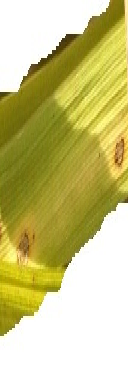

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [ ]:
## Finding max value from predition list and comaparing original value vs predicted
# print("Originally : ",all_labels[np.argmax(y_test[10])])
# print("Predicted using model1: ",all_labels[np.argmax(y_pred1[10])])

### Observation:
- The abovementioned class prediction by the trained model with SGD optimizer was 91.6% Accurate.

Case--> II:
Let us use the same model architecture, Model 2 only by replacing the Optimizer by Adam()

In [ ]:
num_classes = 3

# Define model architecture with regularization (Adam optimizer)
model2 = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.L2(0.01),
                  input_shape=(384, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='swish',
                  kernel_regularizer=regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='gelu',
                  kernel_regularizer=regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(units=256, activation='relu',
                 kernel_regularizer=regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.12),
    layers.Dense(units=128, activation='relu',
                 kernel_regularizer=regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.12),
    layers.Dense(units=num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=80,
    restore_best_weights=True,
    min_delta=0.001
)

# Define Reduce Learning Rate on Plateau
rlrp = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=80,
    min_lr=1e-6
)

In [ ]:
opt2 = Adam(
    learning_rate=0.001,  # Initial learning rate, will be adjusted by cosine annealing
    beta_1=0.9,
    beta_2=0.999,  # Default value, helps with stability
    epsilon=1e-8,  # Slightly higher epsilon for numerical stability
    decay=1e-6  # Weight decay (L2 regularization)
)
cosine_callback = LearningRateScheduler(cosine_annealing, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Compile the model
model2.compile(
    loss='categorical_crossentropy',
    optimizer=opt2,
    metrics=[
        'accuracy',
        #Accuracy(),
        Precision(),
        Recall(),
        AUC(),
        F1Score(average='macro')  # F1-score, macro average
    ]
)



In [ ]:
# Train model
epochs = 500

history2 = model2.fit(
    x_train_aug, y_train_aug,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    verbose=1,
    callbacks=[early_stop, cosine_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.7005 - auc_1: 0.8525 - f1_score: 0.7028 - loss: 5.3728 - precision_1: 0.7126 - recall_1: 0.6591 - val_accuracy: 0.3158 - val_auc_1: 0.5374 - val_f1_score: 0.1600 - val_loss: 5.4141 - val_precision_1: 0.3333 - val_recall_1: 0.2632 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009998914858122914.
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8521 - auc_1: 0.9591 - f1_score: 0.8518 - loss: 4.4491 - precision_1: 0.8651 - recall_1: 0.8386 - val_accuracy: 0.3158 - val_auc_1: 0.5346 - val_f1_score: 0.1600 - val_loss: 5.4526 - val_precision_1: 0.3158 - val_recall_1: 0.3158 - learning_rate: 9.9989e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009994572805174116.
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8707 - auc_1: 0.9749 - f1_score: 0.8702 - loss: 3

In [ ]:
print("[INFO] Calculating model accuracy (Model2)")
scores2 = model2.evaluate(x_test, y_test)
print(f"Test Accuracy using Model1: {scores2[1]*100}")

[INFO] Calculating model accuracy (Model2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9167 - auc_1: 0.9714 - f1_score: 0.9165 - loss: 0.6471 - precision_1: 0.9167 - recall_1: 0.9167
Test Accuracy using Model1: 91.66666865348816


In [ ]:
# Predicting the test data using this model
y_pred2 = model2.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


In [ ]:
y_pred2

array([[2.06337473e-03, 1.27568170e-02, 9.85179782e-01],
       [1.35339552e-03, 9.97366726e-01, 1.27991335e-03],
       [1.52975146e-03, 1.51207354e-02, 9.83349562e-01],
       [2.63623060e-05, 9.99956012e-01, 1.75893911e-05],
       [9.92121577e-01, 1.22854812e-03, 6.64990675e-03],
       [1.70882689e-04, 6.23441897e-02, 9.37484980e-01],
       [9.95133936e-01, 4.52948920e-03, 3.36505298e-04],
       [8.41497723e-03, 1.15490948e-05, 9.91573453e-01],
       [9.98299837e-01, 1.56660657e-03, 1.33488429e-04],
       [1.79065540e-02, 8.81039917e-01, 1.01053566e-01],
       [1.80805544e-03, 9.97473776e-01, 7.18239287e-04],
       [1.47792637e-01, 8.51223290e-01, 9.84112034e-04],
       [9.90037680e-01, 9.17890854e-03, 7.83412077e-04],
       [7.55239278e-04, 6.14958303e-03, 9.93095100e-01],
       [9.23618197e-01, 7.60296658e-02, 3.52123432e-04],
       [5.35842400e-06, 3.53003154e-04, 9.99641657e-01],
       [9.95430470e-01, 4.56159795e-03, 7.96052336e-06],
       [7.94783473e-01, 2.34397

In [ ]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
y_test_pred_class2 = np.argmax(y_pred2, axis=1)

In [ ]:
print(y_test_pred_class2)

[2 1 2 1 0 2 0 2 0 1 1 1 0 2 0 2 0 0 1 2 1 0 0 1]


In [ ]:
print(y_test_class)

[1 1 0 1 0 1 0 2 0 1 1 1 0 2 0 2 0 0 1 1 1 0 0 1]


In [ ]:
y_pred2_disease = label_to_classes_map(y_test_pred_class2)
y_test_disease = label_to_classes_map(y_test_class)

In [ ]:
# test_class = y_test_class.map(disease_dict)
# predicted_class2 = y_test_pred_class2.map(disease_dict)
# print('Actual class':,test_class)
# print('Predicted class':, predicted_class2)

In [ ]:
y_pred2_disease = label_to_classes_map(y_test_pred_class2)
y_test_disease = label_to_classes_map(y_test_class)

In [ ]:
#Converting test and predictions2 to Tensor
y_pred2_disease = tf.constant(y_pred2_disease)
y_test_disease = tf.constant(y_test_disease)

In [ ]:
accur2 = calculate_equal_percentage(y_test_disease,y_pred2_disease)
acc_per2= accur2.numpy().round(2)
print(f"Accuracy of model 1 based on Adam Optimizer: {acc_per2}%")

Accuracy of model 1 based on Adam Optimizer: 83.33%


In [ ]:
# Checking prediction accuracy
accuracy2 = Accuracy()(y_test_class, y_test_pred_class2)
print(accuracy2)

tf.Tensor(0.8333333, shape=(), dtype=float32)


In [ ]:
model_save_path = '/content/gdrive/MyDrive/Machine_Learning/Models/TensorFlow/RiceLeafDisease/Adam/'
tf.saved_model.save(model2, model_save_path + 'model2')


In [ ]:
model2.evaluate(x_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9167 - auc_1: 0.9714 - f1_score: 0.9165 - loss: 0.6471 - precision_1: 0.9167 - recall_1: 0.9167


[0.6470604538917542,
 0.9166666865348816,
 0.9166666865348816,
 0.9166666865348816,
 0.9713540077209473,
 0.9165032505989075]

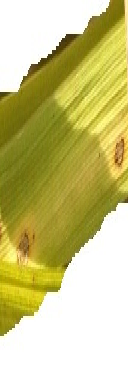

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

### Observation:
- The abovementioned class prediction by the trained model with Adam optimizer was 91.6% Accurate.

Case--> III:
Let us try some changes in model architecture this time

```
# This is formatted as code
```

o Adam()

In [ ]:
num_classes = 3

model3 = Sequential([
    # Conv Block 1
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(384, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Conv Block 2
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Conv Block 3
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),  # Increased units
    layers.Dropout(0.3),  # Increased dropout rate
    layers.Dense(units=num_classes, activation='softmax')
])

# Compile model
model3.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        #Accuracy(),
        Precision(),
        Recall(),
        AUC(),
        F1Score(average='macro')  # F1-score, macro average
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Training the model with Batch SGD model as initialized above with sample batch size:16 for 500 epochs
epochs=500
batch_size=16
history3 = model3.fit(x_train_aug, y_train_aug, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val),verbose=2)

Epoch 1/500
60/60 - 17s - 288ms/step - accuracy: 0.6177 - auc_2: 0.7610 - f1_score: 0.6173 - loss: 11.2488 - precision_2: 0.6188 - recall_2: 0.6156 - val_accuracy: 0.3158 - val_auc_2: 0.4868 - val_f1_score: 0.1600 - val_loss: 11.3733 - val_precision_2: 0.3158 - val_recall_2: 0.3158
Epoch 2/500
60/60 - 1s - 15ms/step - accuracy: 0.6354 - auc_2: 0.8026 - f1_score: 0.6352 - loss: 2.1745 - precision_2: 0.7094 - recall_2: 0.5417 - val_accuracy: 0.3158 - val_auc_2: 0.4868 - val_f1_score: 0.1600 - val_loss: 42.1612 - val_precision_2: 0.3158 - val_recall_2: 0.3158
Epoch 3/500
60/60 - 1s - 16ms/step - accuracy: 0.6792 - auc_2: 0.8619 - f1_score: 0.6791 - loss: 0.7492 - precision_2: 0.7589 - recall_2: 0.5802 - val_accuracy: 0.4211 - val_auc_2: 0.5658 - val_f1_score: 0.3406 - val_loss: 32.2847 - val_precision_2: 0.4211 - val_recall_2: 0.4211
Epoch 4/500
60/60 - 1s - 15ms/step - accuracy: 0.7281 - auc_2: 0.8871 - f1_score: 0.7282 - loss: 0.8477 - precision_2: 0.7984 - recall_2: 0.6313 - val_accura

### Plotting the training graph of model-3 through various epochs
Let's plot the accuracy of the model for the trainig history.

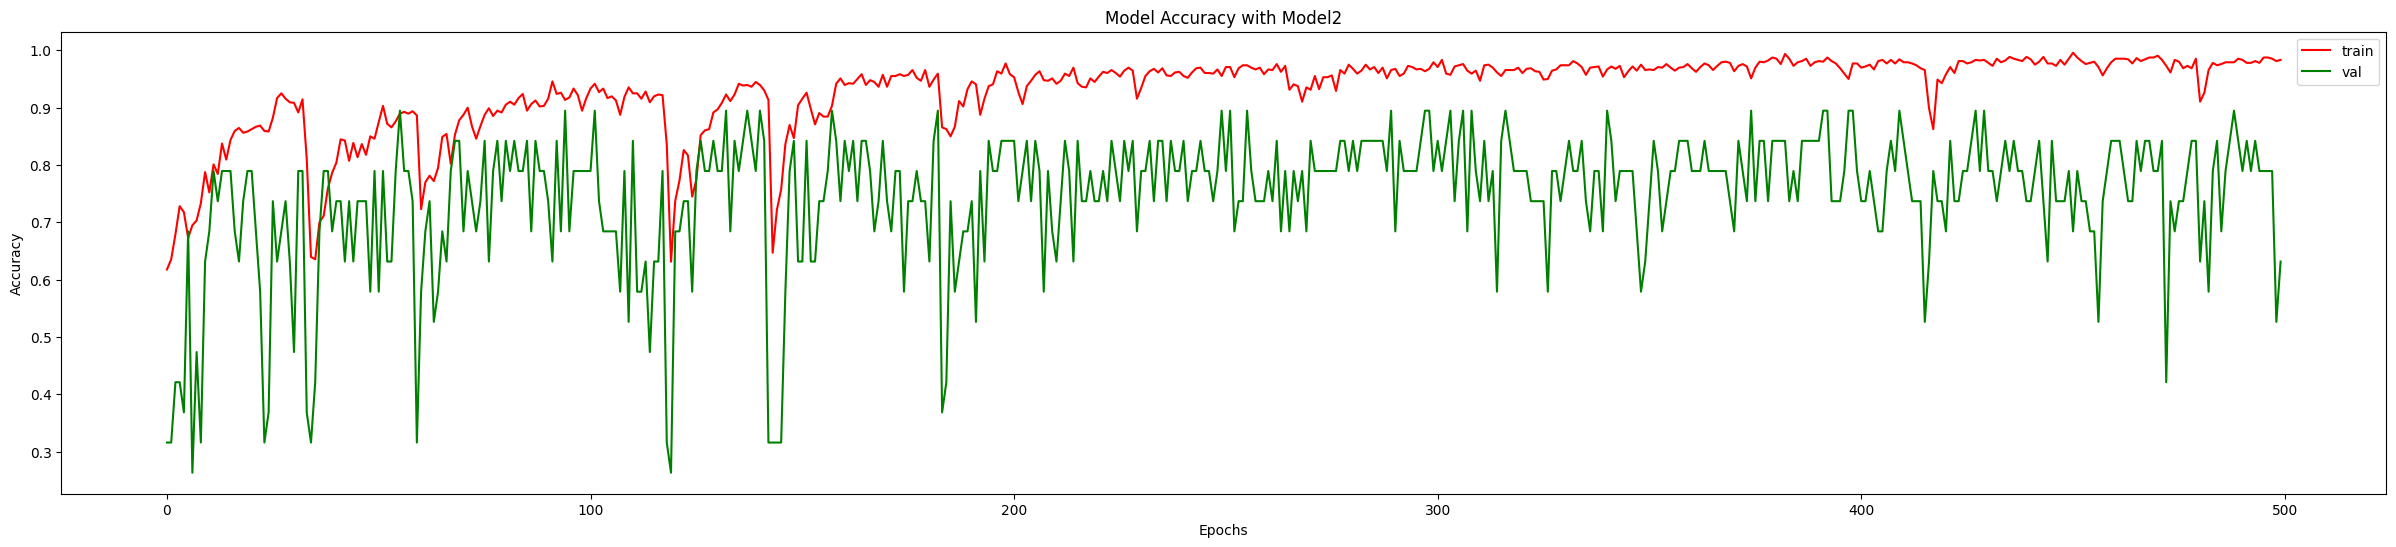

In [ ]:
#Plot the training history
plt.figure(figsize=(30, 6))
plt.title('Plot of training Epoches with Model3 - AdamW')
plt.plot(history3.history['accuracy'], color='r')
plt.plot(history3.history['val_accuracy'], color='g')
plt.title('Model Accuracy with Model2')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

- Let us evaluate model3

In [ ]:
print("[INFO] Calculating model accuracy (Model2)")
scores3 = model3.evaluate(x_test, y_test)
print(f"Test Accuracy using Model3: {scores3[1]*100}")

[INFO] Calculating model accuracy (Model2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6667 - auc_2: 0.8060 - f1_score: 0.6655 - loss: 25.3766 - precision_2: 0.6667 - recall_2: 0.6667
Test Accuracy using Model3: 66.66666865348816


In [ ]:
# Predicting the test data using this model
y_pred3 = model3.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


In [ ]:
y_pred3

array([[1.9349711e-04, 6.7676687e-05, 9.9973887e-01],
       [5.8856678e-26, 1.0000000e+00, 1.1770907e-43],
       [9.6075382e-08, 9.9999988e-01, 5.4854858e-09],
       [2.0205354e-07, 9.9999976e-01, 2.9309761e-09],
       [1.0000000e+00, 1.4342791e-34, 1.0699803e-34],
       [6.8070582e-04, 9.9775851e-01, 1.5607724e-03],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [4.9161478e-08, 4.3921782e-09, 1.0000000e+00],
       [1.0000000e+00, 1.6363276e-30, 4.8131054e-30],
       [1.3097020e-02, 9.7872841e-01, 8.1744818e-03],
       [1.5350368e-08, 1.0000000e+00, 9.9617883e-13],
       [9.5856341e-04, 2.4217710e-02, 9.7482377e-01],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [4.4099000e-04, 6.4401436e-03, 9.9311888e-01],
       [1.0000000e+00, 5.7387326e-22, 1.5324829e-19],
       [3.3674450e-03, 5.0023305e-01, 4.9639946e-01],
       [1.0000000e+00, 1.4102536e-29, 4.3321565e-28],
       [8.6072929e-02, 3.3100086e-01, 5.8292621e-01],
       [0.0000000e+00, 1.000

In [ ]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
y_test_pred_class3 = np.argmax(y_pred3, axis=1)

In [ ]:
print(y_test_pred_class3)

[2 1 1 1 0 1 0 2 0 1 1 2 0 2 0 1 0 2 1 2 1 0 0 2]


In [ ]:
print(y_test_class)

[1 1 0 1 0 1 0 2 0 1 1 1 0 2 0 2 0 0 1 1 1 0 0 1]


In [ ]:
y_pred3_disease = label_to_classes_map(y_test_pred_class3)
y_test_disease = label_to_classes_map(y_test_class)

In [ ]:
#Converting test and predictions2 to Tensor
y_pred3_disease = tf.constant(y_pred3_disease)
y_test_disease = tf.constant(y_test_disease)

In [ ]:
accur3 = calculate_equal_percentage(y_test_disease,y_pred3_disease)
acc_per3= accur3.numpy().round(2)
print(f"Accuracy of model 3 based on AdamW Optimizer: {acc_per3}%")

Accuracy of model 3 based on AdamW Optimizer: 70.83%


In [ ]:
# Checking prediction accuracy
accuracy3 = Accuracy()(y_test_class, y_test_pred_class3)
print(accuracy3)

tf.Tensor(0.7083333, shape=(), dtype=float32)


In [ ]:
model_save_path = '/content/gdrive/MyDrive/Machine_Learning/Models/TensorFlow/RiceLeafDisease/AdamW/'
tf.saved_model.save(model3, model_save_path + 'model3')


In [ ]:
model3.evaluate(x_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6667 - auc_2: 0.8060 - f1_score: 0.6655 - loss: 25.3766 - precision_2: 0.6667 - recall_2: 0.6667


[25.37660789489746,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.8059895038604736,
 0.6655228137969971]

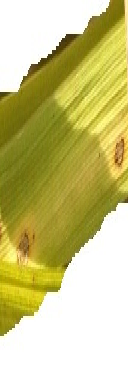

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

### Observation:
- The abovementioned class prediction by the trained model with Adam optimizer was 91.6% Accurate.

In [ ]:
model3.evaluate(x_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6667 - auc_2: 0.8060 - f1_score: 0.6655 - loss: 25.3766 - precision_2: 0.6667 - recall_2: 0.6667


[25.37660789489746,
 0.6666666865348816,
 0.6666666865348816,
 0.6666666865348816,
 0.8059895038604736,
 0.6655228137969971]

### Observations:
From the plot, it can be observed that:
- The train accuracy for this model is high. But, validation accuracy is very poor


### Checking for Test Accuracy using model3
- Now, let's check the accuracy of for test data using Model2.

In [ ]:
print("[INFO] Calculating model accuracy (Model2)")
scores2 = model2.evaluate(x_test, y_test)
print(f"Test Accuracy(Model2): {scores2[1]*100}")

[INFO] Calculating model accuracy (Model2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9167 - auc_1: 0.9714 - f1_score: 0.9165 - loss: 0.6471 - precision_1: 0.9167 - recall_1: 0.9167
Test Accuracy(Model2): 91.66666865348816


In [ ]:
# Predicting the test data using this model
y_pred3 = model3.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


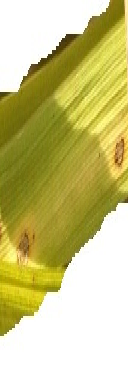

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [ ]:
# # Finding max value from predition list and comaparing original value vs predicted
# print("Originally : ",all_labels[np.argmax(y_test[10])])
# print("Predicted using Model2: ",all_labels[np.argmax(y_pred2[10])])

### Observation:
- The abovementioned class prediction by the trained model (model2) was correct.

In [ ]:
gdgdf

NameError: name 'gdgdf' is not defined

Case--> III:
Now, let us build a CNN model using MaxPooling2D() instead of AveragePooling2D()

In [ ]:
num_classes = 3
model3 = Sequential([
  layers.Conv2D(filters=256,kernel_size= (3,3), padding='valid', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Flatten(),
  layers.Dense(units=512, activation='relu'),
  layers.Flatten(),
  layers.Dense(units=num_classes,activation='softmax')
])



In [ ]:
# creating a stochastic gradient descent object from keras.optimizers class
opt3 = AdamW(lr=0.001, weight_decay=0.01)

# compile the model with loss function:categorical_crossentropy, SGD optimizer & accuracy metric
model3.compile(loss='categorical_crossentropy',
               optimizer=opt3,
               metrics=
                [
                    'accuracy',
                    #Accuracy(),
                    Precision(),
                    Recall(),
                    AUC(),
                    F1Score(average='macro')  # F1-score, macro average
                ])

In [ ]:
#Training the model with Batch SGD model as initialized above with sample batch size:16 for 500 epochs
epochs=500
batch_size=16
history3 = model3.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val),verbose=100)

### Plotting the training graph of model-1 through various epochs
Let's plot the accuracy of the model for the trainig history.

In [ ]:
#Plot the training history
plt.figure(figsize=(30, 6))
plt.title('Model3')
plt.title('Plot of training Epoches (Model3)')
plt.plot(history3.history['accuracy'], color='r')
plt.plot(history3.history['val_accuracy'], color='g')
plt.title('Model Accuracy (Model3)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

### Observations:
From the plot, it can be observed that:
- The train accuracy is very high (>0.95)
- However, the validation accuracy is very less (<0.60)

### Checking for Test Accuracy
- Now, let's check the accuracy of the trained model (Model3) for test data.

In [ ]:
print("[INFO] Calculating model accuracy (Model1)")
scores3 = model3.evaluate(x_test, y_test)
print(f"Test Accuracy using Model3: {scores3[1]*100}")

In [ ]:
# Predicting the test data using this model
y_pred3 = model3.predict(x_test)

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [ ]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted using model1: ",all_labels[np.argmax(y_pred3[10])])

### Observation:
- The abovementioned class prediction by the trained model (model3) was correct.

### Conclusion:
We built and trained the 3 configurations of Covolutional Neural Network (CNN) models using Gradient Descent Optimizer:

- Model1-using sequential 2D covolutional layers, Averagepooling layers, Flatteninglayer, dense layer & activation layer & got test accuracy: 62.5%

- Model2-using another sequential 2D covolutional layers, Averagepooling layers, Flatteninglayer, dense layer & activation layer & got test accuracy: 54.17%

- Model3-using another sequential 2D covolutional layers, Maxpooling layers, Flatteninglayer, dense layer & activation layer & got test accuracy: 58.33%

- We are concluding that model1 performed better classification of the unseend images.

- We understand that as Neural Networks require large amount of training data for training more accurate CNN models the total 77 images used for training the model are not sufficient to improve the model accuracy.

- If we had more images to train upon it would have been possible to train the CNN model more accurately and hence to attain higher accuracy to predict the test images.